# Clasificador de radiografías

## Detección de neumonía

### 1. Importar las librerias y el entorno de trabajo

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm #barra de progreso`
import cv2
from glob import glob

#para redimencionar
import sklearn
import skimage
from skimage.transform import resize

import random
#Usaremos datetime para nombrar archivos
import datetime

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from skimage.color import rgb2gray

print(tf.__version__)


2.9.1


### 2. Conectar con el archivo

In [6]:
train_dir = "chest_xray/train/"
test_dir =  "chest_xray/test/"

LOAD_FROM_IMAGES = False

def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (150, 150, 3),mode='constant',anti_aliasing=True)
                    img_file = rgb2gray(img_file)
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y


if LOAD_FROM_IMAGES == False:
    #cargamos las imágenes a los arrays
    X_train, y_train = get_data(train_dir)
    X_test, y_test= get_data(test_dir)
    
    #grabamos los arrays en archivos
    np.save('xtrain.npy', X_train)
    np.save('ytrain.npy', y_train)
    np.save('xtest.npy', X_test)
    np.save('ytest.npy', y_test)
else:
    #cargamos los arrays anteriormente grabados
    X_train = np.load('xtrain.npy')
    y_train = np.load('ytrain.npy')
    X_test = np.load('xtest.npy')
    y_test = np.load('ytest.npy')

100%|██████████| 390/390 [01:06<00:00,  5.84it/s]


### 3. Exploración de las imágenes contenida en los dataset

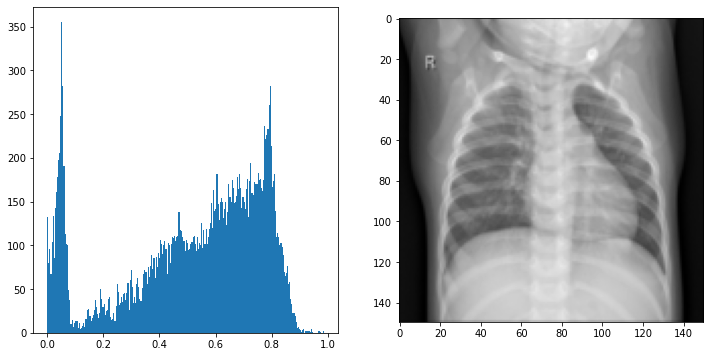

In [7]:
def plotHistogram(a):
    plt.figure(figsize=(12,6))
    plt.subplot(1, 2, 1)
    plt.hist(a.ravel(), bins=255)
    plt.subplot(1, 2, 2)
    plt.imshow(a, cmap='gray', vmin=0, vmax=1)
    plt.show()
    
plotHistogram(X_train[3])

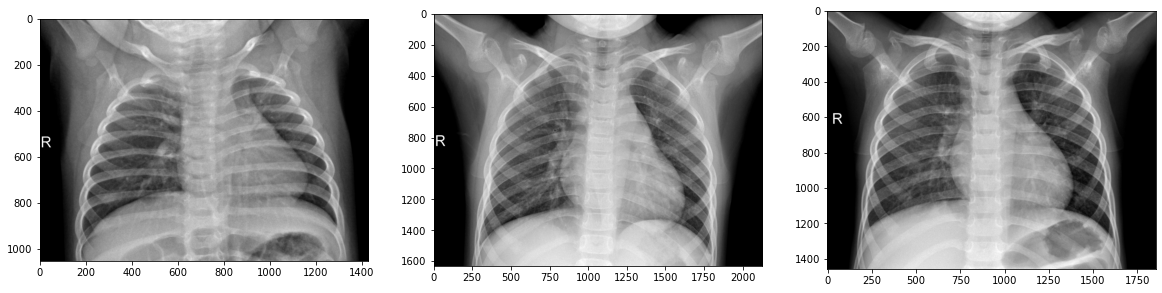

In [8]:
multipleImages = glob('chest_xray/train/NORMAL/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)

No Neumonía


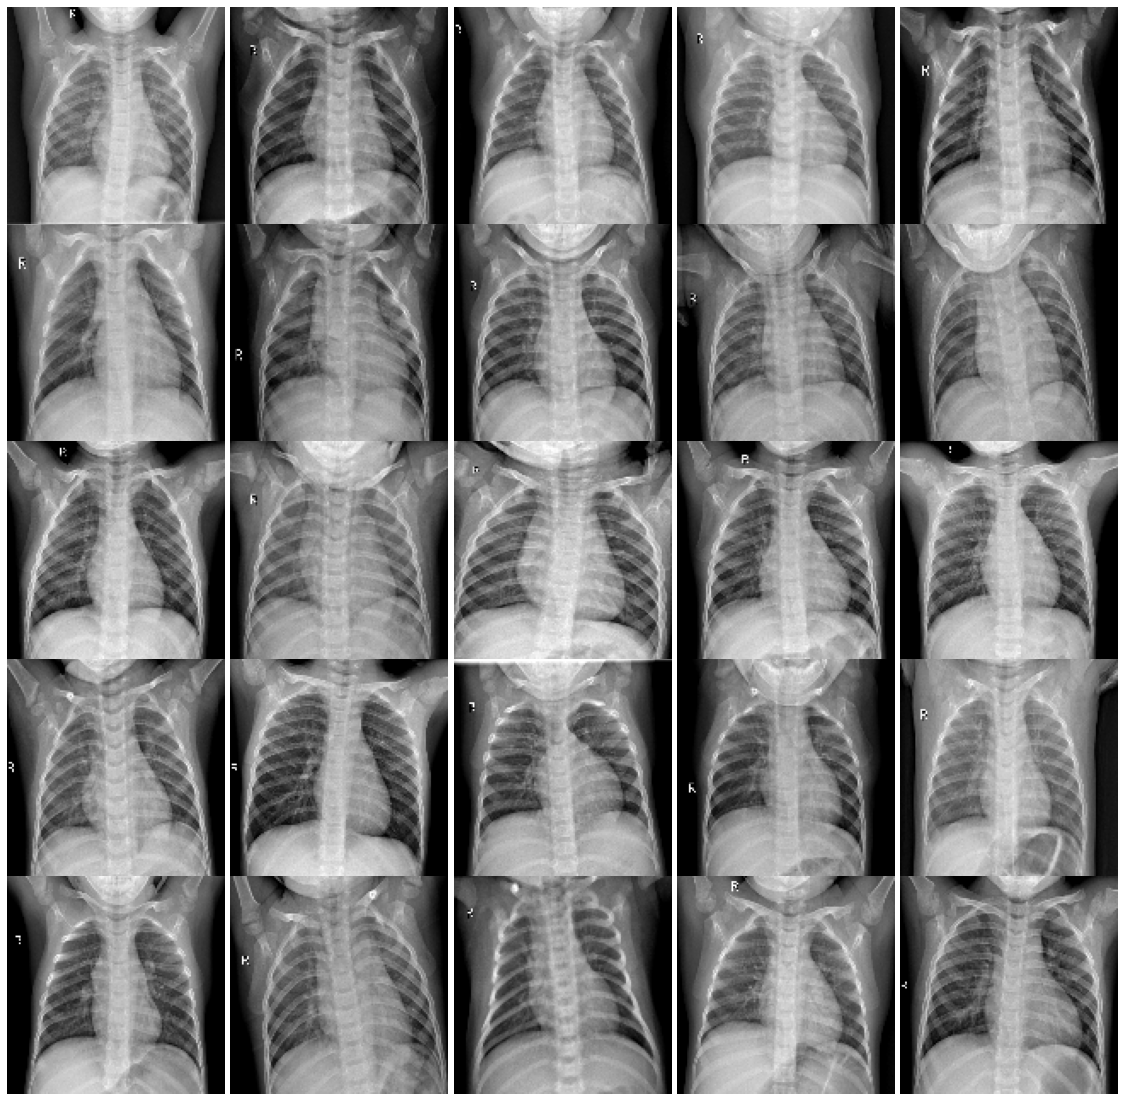

In [9]:
print("No Neumonía")
multipleImages = glob('chest_xray/train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) 
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

Si neumonía


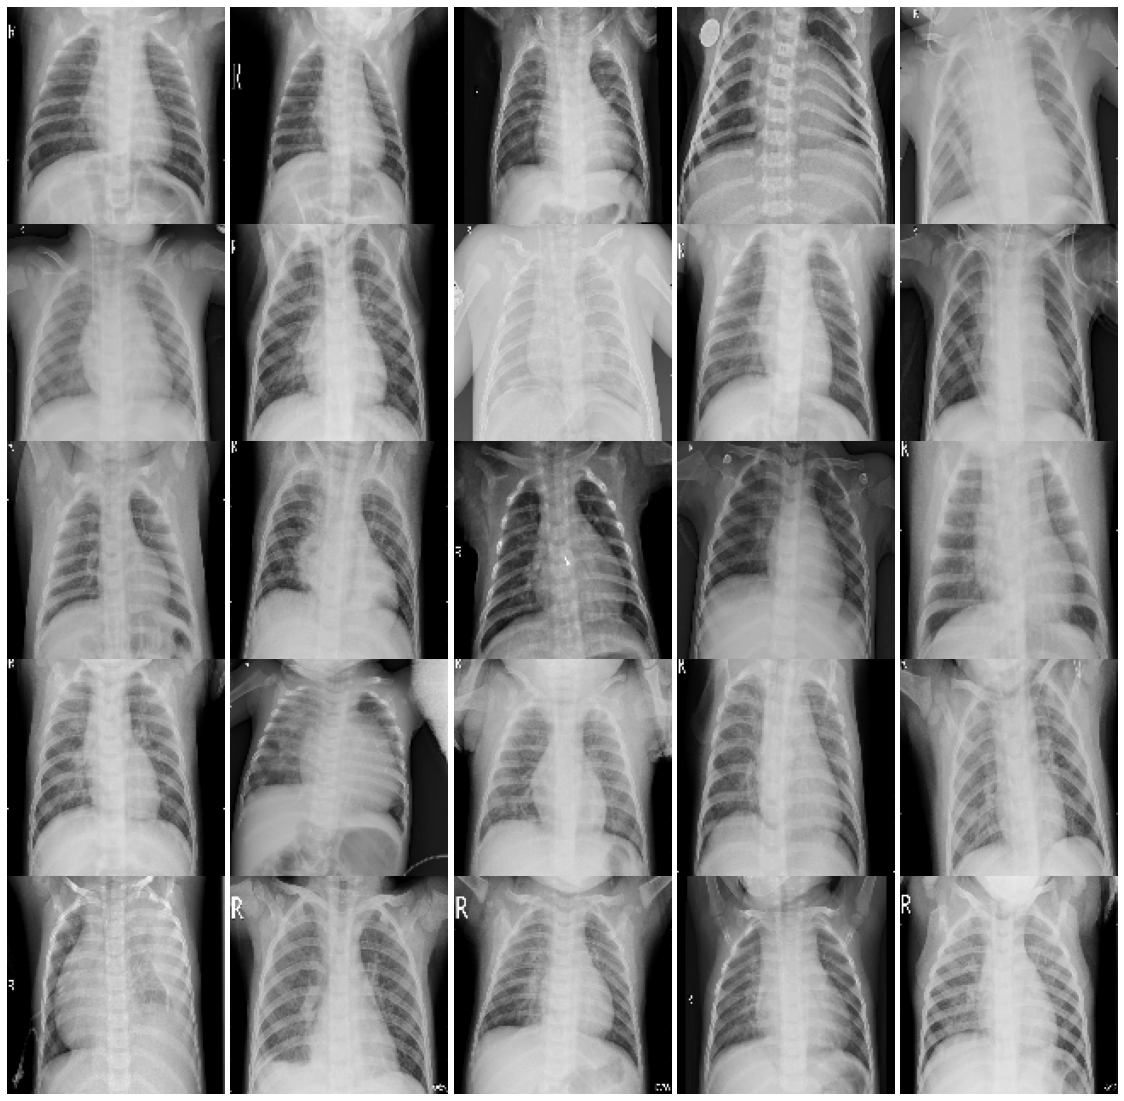

In [10]:
print("Si neumonía")
multipleImages = glob('chest_xray/train/PNEUMONIA/**')
i_ = 0
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

{0: 'No Neumonía', 1: 'Si Neumonía'}


C:\Users\pedro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


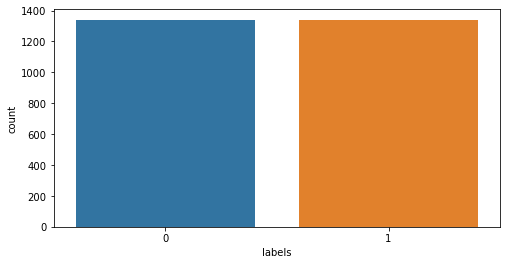

In [11]:
import seaborn as sns

plt.figure(figsize=(8,4))
map_characters = {0: 'No Neumonía', 1: 'Si Neumonía'}
dict_characters=map_characters

df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

### 4. Preparación y ajuste de las imágenes para su entrenamiento 

In [12]:
"""
X_trainReshaped.shape
y_train
"""


'\nX_trainReshaped.shape\ny_train\n'

In [13]:
X_trainReshaped = X_train.reshape(len(X_train),150,150,1)
X_testReshaped = X_test.reshape(len(X_test),150,150,1)

#### 4.1 Creación del modelo

In [14]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

#### 4.2 Entrenamiento del modelo

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)

model.fit(X_trainReshaped, 
          y_train, 
          epochs=20,
          validation_data = (X_testReshaped,y_test),
          callbacks=[tensorboard_callback])

Epoch 1/20
84/84 [==============================] - 57s 661ms/step - loss: 0.4309 - accuracy: 0.7830 - val_loss: 0.3605 - val_accuracy: 0.8429
Epoch 2/20
84/84 [==============================] - 52s 615ms/step - loss: 0.1775 - accuracy: 0.9310 - val_loss: 0.4367 - val_accuracy: 0.8429
Epoch 3/20
84/84 [==============================] - 51s 612ms/step - loss: 0.1838 - accuracy: 0.9329 - val_loss: 0.4314 - val_accuracy: 0.8061
Epoch 4/20
84/84 [==============================] - 51s 607ms/step - loss: 0.1390 - accuracy: 0.9530 - val_loss: 0.6349 - val_accuracy: 0.8173
Epoch 5/20
84/84 [==============================] - 51s 613ms/step - loss: 0.1073 - accuracy: 0.9575 - val_loss: 1.0518 - val_accuracy: 0.7516
Epoch 6/20
84/84 [==============================] - 51s 603ms/step - loss: 0.0774 - accuracy: 0.9709 - val_loss: 1.4150 - val_accuracy: 0.7356
Epoch 7/20
84/84 [==============================] - 52s 624ms/step - loss: 0.0681 - accuracy: 0.9724 - val_loss: 0.5576 - val_accuracy: 0.8365

### 5. Evaluación de la precisión en las imágenes

In [16]:
test_loss, test_acc = model.evaluate(X_testReshaped, y_test)
print(test_acc)

20/20 [==============================] - 3s 147ms/step - loss: 1.7188 - accuracy: 0.7949
0.7948718070983887


In [17]:
test_loss, test_acc = model.evaluate(X_trainReshaped, y_train)

84/84 [==============================] - 13s 152ms/step - loss: 9.3116e-04 - accuracy: 1.0000
